<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="resources/img/softbutterfly-logo.png" class="pull-left" style="display: block; height: 40px; margin: 0;"><img src="resources/img/jupyter-logo.png" class="pull-right"  style="display: block; height: 20px; margin-top: 10px;">
</div>

# El modelo de Kroning-Penney<br><small>Solución Numérica</small>

__Martín Josemaría Vuelta Rojas__<br>
[`@zodiacfireworks`](https://github.com/zodiacfireworks)

_Universidad Nacional Mayor de San Marcos_<br>
Facultad de Ciencias Físicas<br>
(`martin.vuelta@unmsm.edu.pe`)

---

## 1. Ajustes Gráficos

In [12]:
%matplotlib inline

In [13]:
from distutils.spawn import find_executable

from matplotlib.font_manager import *
from matplotlib.collections import *
from matplotlib.patches import *
from matplotlib.pylab import *
from matplotlib import colors

import seaborn

rem = 16

seaborn.set(context='notebook', style='darkgrid')

ioff()

rc('lines', linewidth=1)
rc('font', family='serif')
rc('font', size=rem)
rc('axes', titlepad=1.500*rem)
rc('axes', titlesize=1.728*rem)
rc('axes', labelsize=1.200*rem)
rc('legend', fontsize=1.000*rem)
rc('xtick', labelsize=0.833*rem)
rc('ytick', labelsize=0.833*rem)

if find_executable('latex'):
    rc('text', usetex=True)

## 2. Funciones útiles

In [14]:
import numpy
from numpy import *
from scipy.integrate import simps

### 2.1. Segunda derivada

In [15]:
def second_derivative(data, h):
    out = numpy.array(data)
    for i in range(1, len(data) - 1):
        out[i] = data[i + 1] - 2 * data[i] + data[i - 1]
    out = out / (h * h)
    out[0] = out[1]
    out[-1] = out[-2]

    out[0] = (data[2] - 2 * data[1] + data[0])/(h**2)
    out[-1] = (data[-1] - 2 * data[-1-1] + data[-1-2])/(h**2)
    
    return out

### 2.2. $\theta$ de Heaviside

In [16]:
def heaviside(x):
    out = numpy.zeros_like(x)
    out[x >= 0] = 1.0
    
    return out

### 2.3. Obtención de las matrices $T$, $V$ y $S$

In [17]:
def get_stv(values_n, data_basis, data_potential, x):
    S = numpy.zeros(shape=(len(values_n), len(values_n)))
    T = numpy.zeros(shape=(len(values_n), len(values_n)))
    V = numpy.zeros(shape=(len(values_n), len(values_n)))
    
    for m, mval in enumerate(values_n):
        for n, nval in enumerate(values_n):
            S[m, n] = float("%0.4f" % simps(numpy.conjugate(
                data_basis[mval]) * data_basis[nval], x).real)
    
            T[m, n] = simps(numpy.conjugate(
                data_basis[mval]) * (-0.5) * second_derivative(
                data_basis[nval], x[1] - x[0]), x).real
        
            V[m, n] = simps(numpy.conjugate(
                data_basis[mval]) * data_potential * data_basis[nval], x).real
            
    return S, T, V

## 3. Solución numérica de la ecuación de Schrödinger

### 3.1. Función de potencial de barrera

In [18]:
# x: posición
# Vo: Valor del ptencial
# width: Ancho del pozo
def potential(x, Vo=1.0, width=1.0):
    return Vo * heaviside(x - width / 2 + 0.25*width) * (1 - heaviside(x - width / 2 - 0.25*width))

### 3.2. Base de ondas planas

In [19]:
# n: Orden de la funcion
# K: vector de onda
# width: ancho del la barrera de potencial
# x: corrdenadas de posicion
def basis_n_K(n, K, width=1.0, x=[1.0]):
    return sqrt(1 / width) * exp(1.0j * (K + 2 * pi * n / width) * x)

### 3.3. Solución numérica de la ecuacion de Schrödinger 

In [20]:
# unidades normalizadas: m = hbar = 1
# Ancho del pozo
width = 1.0
# Numero de divisiones
ndiv = 1000
# K: Numero de onda desde -pi/a hasta pi/a con 50 divisiones
ndiv_k = 100
# Numero de funciones de la base empleadas
N = 15
# Coordenadas de posición
x = numpy.linspace(0, width, ndiv)
# Potencial a lo largo de X
# Valor del potencial: Vo = 50
data_potential = potential(x, Vo=50, width=width)
# valores del orden de las funciones de potencial
values_n = [0]
for n in range(1, N+1):
    values_n.append(n)
    values_n.append(-n)
#
K_arr = numpy.linspace(-pi/width, pi/width, ndiv_k)

A = {}
for m in values_n:
    A[m] = simps(
        numpy.conjugate(basis_n_K(m, 0, width=width, x=x)) * basis_n_K(m, 0, width=width, x=x),
        x
    ).real

# Determinacion de las matrices
# T: energia cinética
T = numpy.zeros(shape=(len(values_n), len(values_n), len(K_arr)))
# V: energia potencial
V = numpy.zeros(shape=(len(values_n), len(values_n), len(K_arr)))
# S: matriz de solapamiento, si la base elegida es ortogonal es igual la identidad
S = numpy.zeros(shape=(len(values_n), len(values_n), len(K_arr)))

for k, K in enumerate(K_arr):
    data_basis = {}
    
    for m in values_n:
        data_basis[m] = basis_n_K(m, K, width=width, x=x) / sqrt(A[m])

    S_, T_, V_ = get_stv(values_n, data_basis, data_potential, x)
    S[:, :, k] = S_
    T[:, :, k] = T_
    V[:, :, k] = V_
    
# Hamiltoniano
H = T + V

# Obtencion de los autovalores del hamiltniano
# Energias
energies = list()

for k, K in enumerate(K_arr):
    eigenenergies, eigenvectors = numpy.linalg.eig(H[:, :, k])
    energies.append(sorted(eigenenergies))
    
energies = numpy.array(energies)

### 3.4. Grafico de las bandas de energía

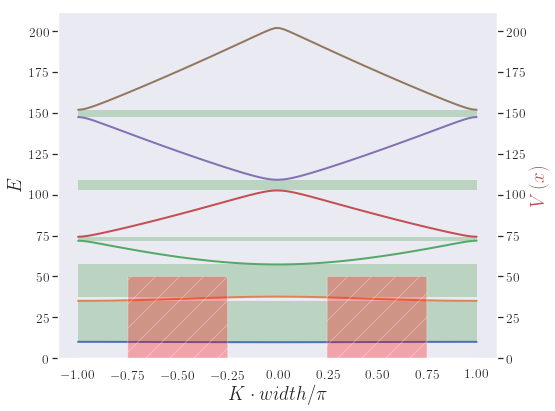

In [21]:
# b = 0.25a
fig = figure(1, figsize=[8, 6])
ax = fig.add_subplot(111)

for n in range(6):
    ax.plot(K_arr * width / pi, energies[:, n], lw=2)

    if n==0:
        min1 = max(energies[:, n])
    else:
        max1 = min(energies[:, n])
        ax.add_patch(Rectangle((min(K_arr) * width / numpy.pi, min1),
                                           2 * max(K_arr) * width / numpy.pi, max1-min1,
                                           facecolor="green",
                                           alpha=0.2, lw=0))
    min1 = max(energies[:, n])

ax.set_xlabel(r"$K \cdot width/\pi$")
ax.set_ylabel(r"$E$")
ax_potential = ax.twinx()
lim_min = min([ax.get_ylim()[0], ax_potential.get_ylim()[0]])
lim_max = max([ax.get_ylim()[1], ax_potential.get_ylim()[1]])
ax_potential.set_ylim(lim_min, lim_max)
ax.set_ylim(lim_min, lim_max)

newx = numpy.sort(numpy.concatenate((x, -x)))
hatch = "/"
alpha=0.3
fcol = "red"
ax_potential.fill_between(x, 0, data_potential, hatch=hatch, facecolor=fcol, alpha=alpha)
ax_potential.fill_between(-x, 0, data_potential, hatch=hatch, facecolor=fcol, alpha=alpha)

ax_potential.set_ylabel(r"$V\left(x\right)$",
                        color="r")
fig.tight_layout()
ax.grid(False)
ax_potential.grid(False)
show()